In [134]:
import pandas as pd     
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import torch
import sklearn
from sklearn import metrics
from sklearn import model_selection
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from torch.utils.data import Dataset, DataLoader, TensorDataset

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## 1 Load Data

In [135]:
# read train and test dataset
train = pd.read_csv('../input/titanic/train.csv')
test = pd.read_csv('../input/titanic/test.csv')

# use to index the submittion file
PassengerId = test['PassengerId']

# process train and test dataset at the same time
all_data = pd.concat([train, test], ignore_index = True)

## 2 Analyse Data

### 2.1 overview

In [136]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [137]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


### 2.2 the relationships between every features and survival

In [138]:
# the number of survival and death
train['Survived'].value_counts()

0    549
1    342
Name: Survived, dtype: int64

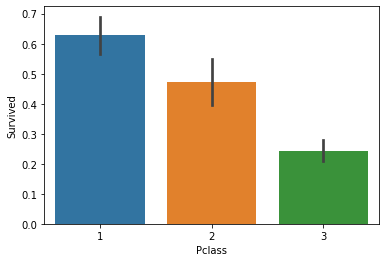

In [139]:
# Pclass：the higher the class, the higher the survival rate
sns.barplot(x = 'Pclass', y = 'Survived', data = train)

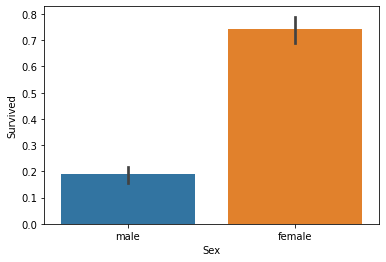

In [140]:
# Sex：female is more likely to survive than male
sns.barplot(x = 'Sex', y = 'Survived', data = train)

Text(12.389771412037035, 0.5, 'density')

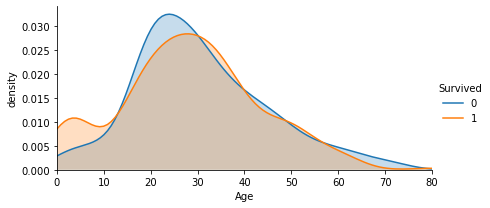

In [141]:
# Age：under 15-year-old there is an apparent differency of survival rate in the same age
facet = sns.FacetGrid(train, hue = 'Survived', aspect = 2)
facet.map(sns.kdeplot, 'Age', shade = True)
facet.set(Xlim = (0, train['Age'].max()))
facet.add_legend()
plt.xlabel('Age')
plt.ylabel('density')

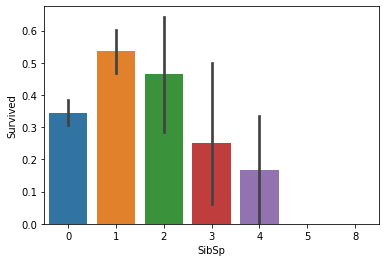

In [142]:
# SibSp：the more medium the number of sublings, the higher survival rate
sns.barplot(x = 'SibSp', y = 'Survived', data = train)

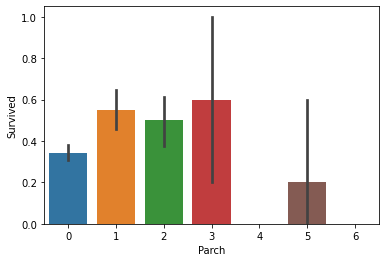

In [143]:
# Parch：the more medium the number of parents and children, the higher survival rate
sns.barplot(x = 'Parch', y = 'Survived', data = train)

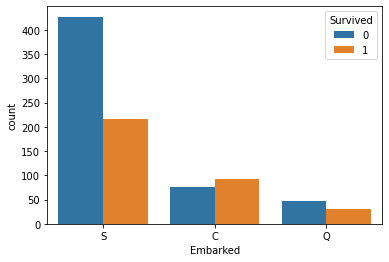

In [144]:
# Embarked：C has the highest survival rate
sns.countplot('Embarked', hue = 'Survived', data = train)

## 3 Process Data

### 3.1 create new features with name, family and ticket

In [145]:
# surname
all_data['Surname'] = all_data['Name'].apply(lambda x : x.split(',')[0].strip())

In [146]:
# Name Title
all_data['Title'] = all_data['Name'].apply(lambda x:x.split(',')[1].split('.')[0].strip())
Title_Dict = {}
Title_Dict.update(dict.fromkeys(['Capt', 'Col', 'Major', 'Dr', 'Rev'], 'Officer'))
Title_Dict.update(dict.fromkeys(['Don', 'Sir', 'the Countess', 'Dona', 'Lady'], 'Royalty'))
Title_Dict.update(dict.fromkeys(['Mme', 'Ms', 'Mrs'], 'Mrs'))
Title_Dict.update(dict.fromkeys(['Mlle', 'Miss'], 'Miss'))
Title_Dict.update(dict.fromkeys(['Mr'], 'Mr'))
Title_Dict.update(dict.fromkeys(['Master', 'Jonkheer'], 'Master'))

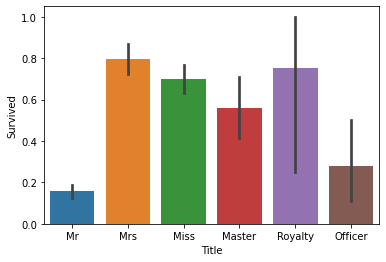

In [147]:
all_data['Title'] = all_data['Title'].map(Title_Dict)
sns.barplot(x = 'Title', y = 'Survived', data = all_data)

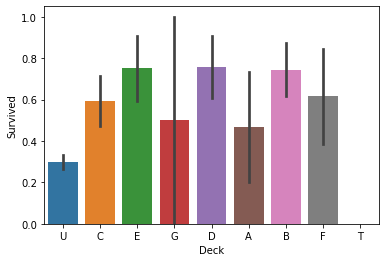

In [148]:
# show the deck using cabin number
# E D B is more likely to survive
all_data['Cabin'] = all_data['Cabin'].fillna('Unknown')
all_data['Deck'] = all_data['Cabin'].str.get(0)
sns.barplot(x = 'Deck', y = 'Survived', data = all_data)

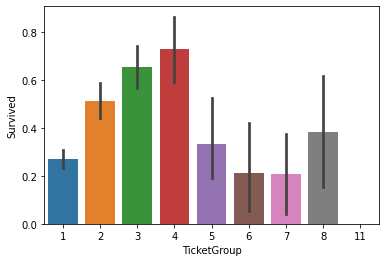

In [149]:
# TicketGroup
Ticket_Count = dict(all_data['Ticket'].value_counts())
all_data['TicketGroup'] = all_data['Ticket'].apply(lambda x : Ticket_Count[x])
sns.barplot(x = 'TicketGroup', y = 'Survived', data = all_data)

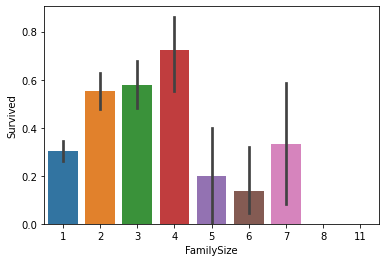

In [150]:
# FamilySize
all_data['FamilySize'] = all_data['SibSp'] + all_data['Parch'] + 1
sns.barplot(x = 'FamilySize', y = 'Survived', data = all_data)

In [151]:
# optimization 1st: IsAlone
all_data['IsAlone'] = 0
all_data.loc[all_data['FamilySize'] == 1, 'IsAlone'] = 1

### 3.2 fill missing values

In [152]:
# Age：the missing rate of Age is quite high, so use random forest to fill it based on Sex, Title and Pclass
all_data[all_data['Age'].isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Surname,Title,Deck,TicketGroup,FamilySize,IsAlone
5,6,0.0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,Unknown,Q,Moran,Mr,U,1,1,1
17,18,1.0,2,"Williams, Mr. Charles Eugene",male,NaN,0,0,244373,13.0000,Unknown,S,Williams,Mr,U,1,1,1
19,20,1.0,3,"Masselmani, Mrs. Fatima",female,NaN,0,0,2649,7.2250,Unknown,C,Masselmani,Mrs,U,1,1,1
26,27,0.0,3,"Emir, Mr. Farred Chehab",male,NaN,0,0,2631,7.2250,Unknown,C,Emir,Mr,U,1,1,1
28,29,1.0,3,"O'Dwyer, Miss. Ellen ""Nellie""",female,NaN,0,0,330959,7.8792,Unknown,Q,O'Dwyer,Miss,U,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1299,1300,NaN,3,"Riordan, Miss. Johanna Hannah""""",female,NaN,0,0,334915,7.7208,Unknown,Q,Riordan,Miss,U,1,1,1
1301,1302,NaN,3,"Naughton, Miss. Hannah",female,NaN,0,0,365237,7.7500,Unknown,Q,Naughton,Miss,U,1,1,1
1304,1305,NaN,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,Unknown,S,Spector,Mr,U,1,1,1
1307,1308,NaN,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,Unknown,S,Ware,Mr,U,1,1,1


In [153]:
from sklearn.ensemble import RandomForestRegressor

age_df = all_data[['Age', 'Pclass', 'Sex', 'Title', 'Parch']]
age_df = pd.get_dummies(age_df)
known_age = age_df[age_df.Age.notnull()].values
unknown_age = age_df[age_df.Age.isnull()].values
y = known_age[:, 0]
X = known_age[:, 1:]
rfr = RandomForestRegressor(random_state=0, n_estimators=100, n_jobs=-1)
rfr.fit(X, y)
predictedAges = rfr.predict(unknown_age[:, 1:])
all_data.loc[(all_data.Age.isnull()), 'Age'] = predictedAges
all_data[all_data['Age'].isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Surname,Title,Deck,TicketGroup,FamilySize,IsAlone


In [154]:
# optimization 1st: CatagoricalAge
all_data['CategoricalAge'] = pd.cut(all_data['Age'], 5)

In [155]:
# Embarked：only two missing values, and set to C according to Pclass，Embarked
all_data[all_data['Embarked'].isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Surname,Title,Deck,TicketGroup,FamilySize,IsAlone,CategoricalAge
61,62,1.0,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN,Icard,Miss,B,2,1,1,"(32.102, 48.068]"
829,830,1.0,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN,Stone,Mrs,B,2,1,1,"(48.068, 64.034]"


In [156]:
all_data.groupby(by = ['Pclass', 'Embarked']).Fare.median()

Pclass  Embarked
1       C           76.7292
        Q           90.0000
        S           52.0000
2       C           15.3146
        Q           12.3500
        S           15.3750
3       C            7.8958
        Q            7.7500
        S            8.0500
Name: Fare, dtype: float64

In [157]:
all_data['Embarked'] = all_data['Embarked'].fillna('C')

In [158]:
# Fare：there is only one missing value, and calculate the median value of fare according to Embarked and Pclass
all_data[all_data['Fare'].isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Surname,Title,Deck,TicketGroup,FamilySize,IsAlone,CategoricalAge
1043,1044,NaN,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NaN,Unknown,S,Storey,Mr,U,1,1,1,"(48.068, 64.034]"


In [159]:
fare = all_data[(all_data['Embarked'] == 'S') & (all_data['Pclass'] == 3)].Fare.median()
all_data['Fare'] = all_data['Fare'].fillna(fare)

In [160]:
all_data[all_data['Fare'].isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Surname,Title,Deck,TicketGroup,FamilySize,IsAlone,CategoricalAge


In [161]:
# optimization 1st: change to a new feature
all_data['CategoricalFare'] = pd.qcut(all_data['Fare'], 4)

In [162]:
all_data.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Surname,Title,Deck,TicketGroup,FamilySize,IsAlone,CategoricalAge,CategoricalFare
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,Unknown,S,Braund,Mr,U,1,2,0,"(16.136, 32.102]","(-0.001, 7.896]"
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Cumings,Mrs,C,2,2,0,"(32.102, 48.068]","(31.275, 512.329]"
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,Unknown,S,Heikkinen,Miss,U,1,1,1,"(16.136, 32.102]","(7.896, 14.454]"


### 3.3 show the correlations

In [163]:
# feature selection
all_data = all_data[['Survived', 'Pclass', 'Sex', 'CategoricalAge', 'CategoricalFare',
                     'Embarked', 'Title', 'IsAlone']]
all_data.head(3)

,Survived,Pclass,Sex,CategoricalAge,CategoricalFare,Embarked,Title,IsAlone
0,0.0,3,male,"(16.136, 32.102]","(-0.001, 7.896]",S,Mr,0
1,1.0,1,female,"(32.102, 48.068]","(31.275, 512.329]",C,Mrs,0
2,1.0,3,female,"(16.136, 32.102]","(7.896, 14.454]",S,Miss,1


In [164]:
# change to category then to numerical
for feature in ['Sex', 'Embarked', 'Title', 'CategoricalAge', 'CategoricalFare']:
    all_data[feature] = all_data[feature].astype('category')
    all_data[feature] = pd.DataFrame({feature: all_data[feature].cat.codes}, index=all_data[feature].index)

In [165]:
all_data.head(3)

,Survived,Pclass,Sex,CategoricalAge,CategoricalFare,Embarked,Title,IsAlone
0,0.0,3,1,1,0,2,2,0
1,1.0,1,0,2,3,0,3,0
2,1.0,3,0,1,1,2,1,1


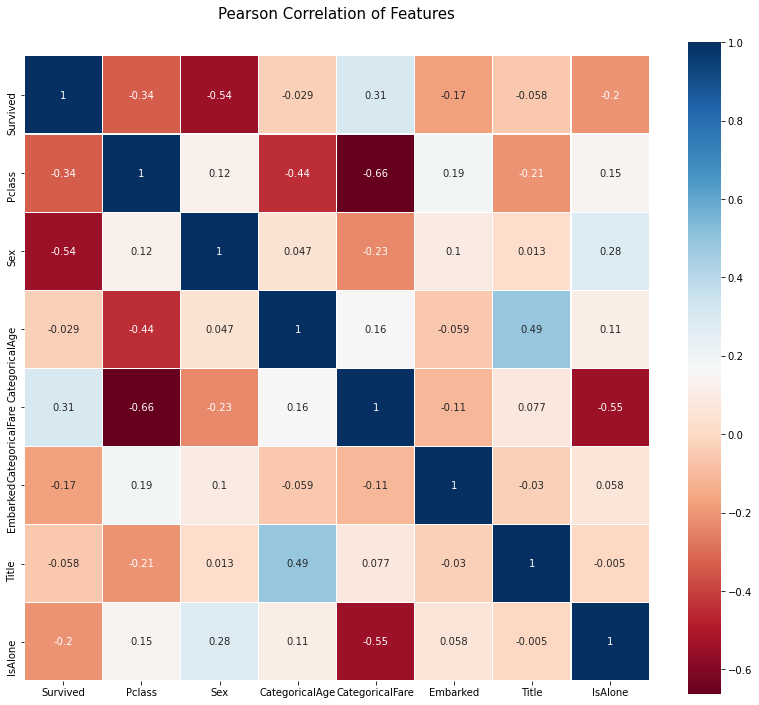

In [166]:
# correlation map
colormap = plt.cm.RdBu
plt.figure(figsize=(14, 12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(all_data.astype(float).corr(), linewidths=0.1, vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)

### 3.4 transform features

In [167]:
train = all_data[all_data['Survived'].notnull()]
test = all_data[all_data['Survived'].isnull()].drop('Survived', axis = 1)
test = test.values
X = train.values[:, 1:]
y = train.values[:, 0]

In [168]:
print(X[:3], y[:3])

[[3. 1. 1. 0. 2. 2. 0.]
 [1. 0. 2. 3. 0. 3. 0.]
 [3. 0. 1. 1. 2. 1. 1.]] [0. 1. 1.]


## 4 Build Model

### 4.1 train model

In [169]:
import tensorflow as tf
import keras 
from keras.layers import Dense, Dropout, Input
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint

In [187]:
def get_model():
    model = Sequential()
    model.add(Dense(units = 32, input_shape = (7,), activation = 'relu'))
    model.add(Dense(units = 64, activation = 'relu'))
    model.add(Dense(units =128, activation = 'relu'))
    model.add(Dense(units = 256, activation = 'relu'))
    model.add(Dense(units = 128, activation = 'relu'))
    model.add(Dropout(0.1))
    model.add(Dense(units = 64, activation = 'relu'))
    model.add(Dropout(0.1))
    model.add(Dense(units = 32, activation = 'relu'))
    model.add(Dropout(0.15))
    model.add(Dense(units = 16, activation = 'relu'))
    model.add(Dense(units = 8, activation = 'relu'))
    model.add(Dense(units =1 , activation = 'sigmoid'))
    
    model.compile(loss = tf.keras.losses.binary_crossentropy,
                  optimizer = tf.keras.optimizers.Adam(),
                  metrics = ['acc'])
    return model

In [ ]:
# save the best model
filepath="weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True,
mode='max')
callbacks_list = [checkpoint]


# create model
model = get_model()

# Fit the model
history = model.fit(X, y, validation_split=0.20, epochs=50, batch_size=32, verbose=1, shuffle=True)
#                    callbacks=callbacks_list)

Epoch 1/50
23/23 [==============================] - 0s 11ms/step - loss: 0.6375 - acc: 0.6067 - val_loss: 0.5299 - val_acc: 0.6425
Epoch 2/50
23/23 [==============================] - 0s 5ms/step - loss: 0.5972 - acc: 0.6250 - val_loss: 0.5074 - val_acc: 0.7486
Epoch 3/50
23/23 [==============================] - 0s 4ms/step - loss: 0.5666 - acc: 0.7121 - val_loss: 0.4776 - val_acc: 0.8101
Epoch 4/50
23/23 [==============================] - 0s 4ms/step - loss: 0.5757 - acc: 0.7163 - val_loss: 0.4539 - val_acc: 0.7989
Epoch 5/50
23/23 [==============================] - 0s 4ms/step - loss: 0.5166 - acc: 0.7753 - val_loss: 0.4436 - val_acc: 0.7933
Epoch 6/50
23/23 [==============================] - 0s 4ms/step - loss: 0.4662 - acc: 0.8034 - val_loss: 0.4131 - val_acc: 0.8436
Epoch 7/50
23/23 [==============================] - 0s 4ms/step - loss: 0.4575 - acc: 0.8062 - val_loss: 0.3964 - val_acc: 0.8268
Epoch 8/50
23/23 [==============================] - 0s 4ms/step - loss: 0.4381 - acc: 0.8

In [ ]:
history = history.history
train_loss = history['loss']
train_acc = history['acc']
val_loss = history['val_loss']
val_acc = history['val_acc']

plt.figure(figsize=[20,9])
plt.plot(train_loss,label="train_loss",color="red")
plt.plot(train_acc,label="train_acc",color="orange")
plt.plot(val_loss,label="val_loss",color="blue")
plt.plot(val_acc,label="val_acc",color="green")
plt.legend()

### 4.3 Cross validation

In [ ]:
# kfold = KFold(n_splits=10, random_state=7)
# results = model_selection.cross_val_score(estimator, X, y, cv=kfold)
# print("Results: %.2f (%.2f) MSE" % (results.mean(), results.std()))

## 5 Predict Data

In [ ]:
#model.load_weights("weights.best.hdf5")

predict = model.predict(test)
predict = (predict > 0.5).astype(int).ravel()

submission = pd.DataFrame({'PassengerId' : PassengerId, 'Survived' : predict.astype(np.int32)})
submission.to_csv(r"submission1.csv", index = False)

In [ ]:
print(predict)

In [ ]:
Y_pred_rand = (model.predict(X) > 0.5).astype(int)
print('Precision : ', np.round(metrics.precision_score(y, Y_pred_rand)*100,2))
print('Accuracy : ', np.round(metrics.accuracy_score(y, Y_pred_rand)*100,2))
print('Recall : ', np.round(metrics.recall_score(y, Y_pred_rand)*100,2))
print('F1 score : ', np.round(metrics.f1_score(y, Y_pred_rand)*100,2))
print('AUC : ', np.round(metrics.roc_auc_score(y, Y_pred_rand)*100,2))

In [ ]:
# plotting the confusion matrix in heatmap
matrix = metrics.confusion_matrix(y, Y_pred_rand)
sns.heatmap(matrix, annot = True, fmt = 'g')
plt.show()